# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [24]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools


# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [25]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [26]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [27]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
     return separable_conv2d_batchnorm(input_layer, filters, strides)


### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [28]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
   
    # TODO Upsample the small input layer using the bilinear_upsample function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    preoutput_layer = separable_conv2d_batchnorm(concatenated_layer, filters)
    output_layer = separable_conv2d_batchnorm(preoutput_layer, filters)
   
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [29]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    f = 32
    encoder_layer1 = encoder_block(inputs, f, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 2*f, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 4*f, 2)
   
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    mid_layer = conv2d_batchnorm(encoder_layer3, 4*f ,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder_layer1 = decoder_block(mid_layer, encoder_layer2, 4*f)
    decoder_layer2 = decoder_block(decoder_layer1, encoder_layer1, 2*f)
    decoder_layer3 = decoder_block(decoder_layer2, inputs, f)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer3)
    
    # Print network shapes
    print(inputs)
    print(encoder_layer1)
    print(encoder_layer2)
    print(encoder_layer3)
    print(mid_layer)
    print(decoder_layer1)
    print(decoder_layer2)
    print(decoder_layer3)
    print(outputs)
    
    return outputs

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 160, 160, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 80, 80, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 40, 40, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 20, 20, 128), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 40, 40, 128), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 80, 80, 64), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 160, 160, 32), dtype=float32)
Tensor("conv2d_2/truediv:0", shape=(?, 160, 160, 3), dtype=float32)


### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
number_of_validation_images = 1184
number_of_training_images = 4131 

learning_rate = 0.0001
num_epochs = 70
batch_size = 40
steps_per_epoch = number_of_training_images // batch_size + 1
validation_steps = number_of_validation_images // batch_size + 1
workers = 10

print("steps per epoch: ", steps_per_epoch)
print("validation steps: ", validation_steps)

steps per epoch:  104
validation steps:  30


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6435747703903069883
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 104831385
locality {
  bus_id: 1
}
incarnation: 6395672364197345718
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0"
]
Epoch 1/70
103/104 [============================>.] - ETA: 1s - loss: 1.1511

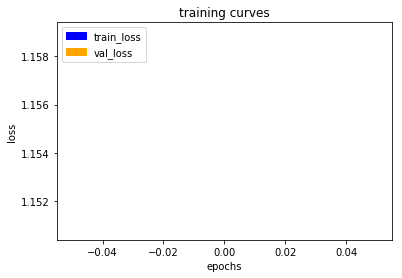

104/104 [==============================] - 186s - loss: 1.1499 - val_loss: 1.1590
Epoch 2/70
103/104 [============================>.] - ETA: 1s - loss: 0.9655

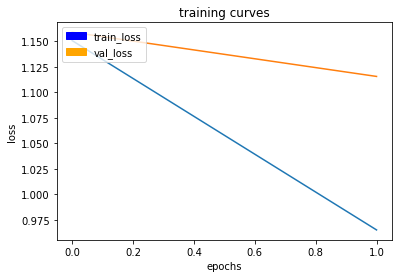

104/104 [==============================] - 129s - loss: 0.9649 - val_loss: 1.1157
Epoch 3/70
103/104 [============================>.] - ETA: 1s - loss: 0.8386

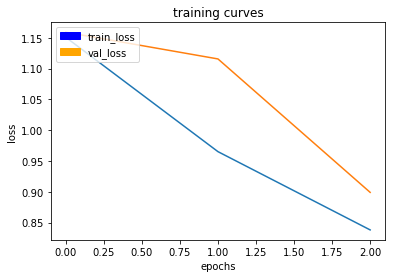

104/104 [==============================] - 136s - loss: 0.8379 - val_loss: 0.8990
Epoch 4/70
103/104 [============================>.] - ETA: 1s - loss: 0.7242

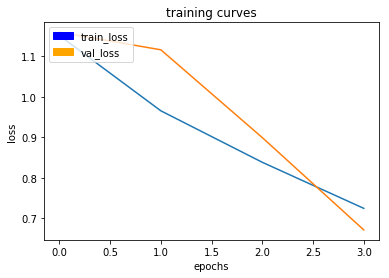

104/104 [==============================] - 130s - loss: 0.7239 - val_loss: 0.6712
Epoch 5/70
103/104 [============================>.] - ETA: 1s - loss: 0.6303

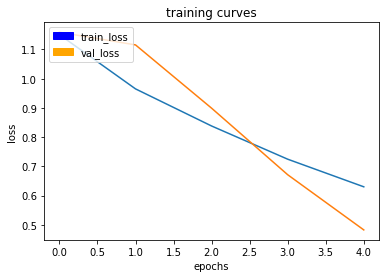

104/104 [==============================] - 134s - loss: 0.6296 - val_loss: 0.4823
Epoch 6/70
103/104 [============================>.] - ETA: 1s - loss: 0.5454

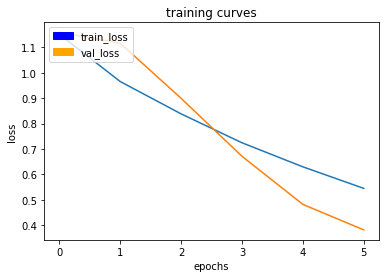

104/104 [==============================] - 134s - loss: 0.5448 - val_loss: 0.3820
Epoch 7/70
103/104 [============================>.] - ETA: 1s - loss: 0.4694

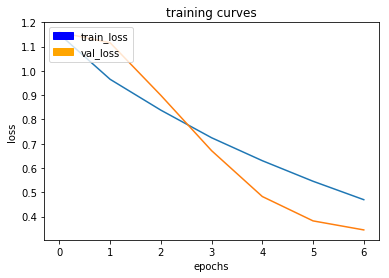

104/104 [==============================] - 133s - loss: 0.4692 - val_loss: 0.3448
Epoch 8/70
103/104 [============================>.] - ETA: 1s - loss: 0.4035

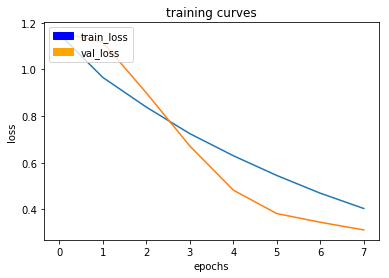

104/104 [==============================] - 132s - loss: 0.4033 - val_loss: 0.3120
Epoch 9/70
103/104 [============================>.] - ETA: 1s - loss: 0.3485

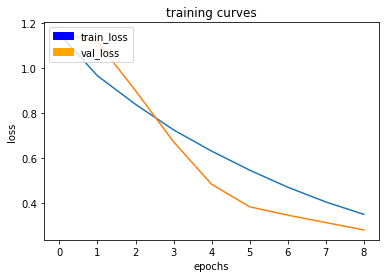

104/104 [==============================] - 133s - loss: 0.3483 - val_loss: 0.2791
Epoch 10/70
103/104 [============================>.] - ETA: 1s - loss: 0.3008

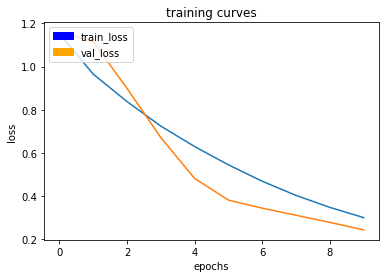

104/104 [==============================] - 139s - loss: 0.3007 - val_loss: 0.2443
Epoch 11/70
103/104 [============================>.] - ETA: 1s - loss: 0.2603

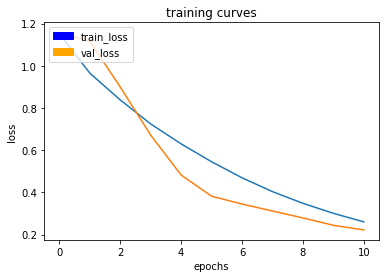

104/104 [==============================] - 141s - loss: 0.2601 - val_loss: 0.2223
Epoch 12/70
103/104 [============================>.] - ETA: 1s - loss: 0.2270

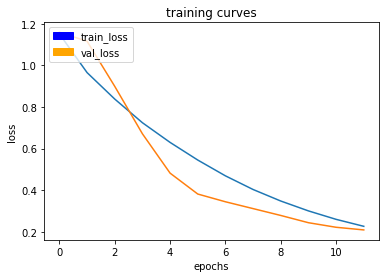

104/104 [==============================] - 140s - loss: 0.2268 - val_loss: 0.2097
Epoch 13/70
103/104 [============================>.] - ETA: 1s - loss: 0.1998

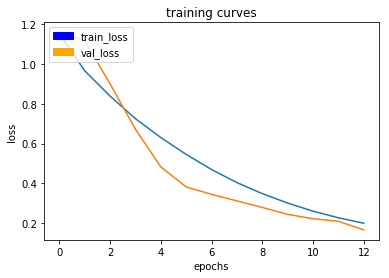

104/104 [==============================] - 142s - loss: 0.1997 - val_loss: 0.1661
Epoch 14/70
103/104 [============================>.] - ETA: 1s - loss: 0.1751

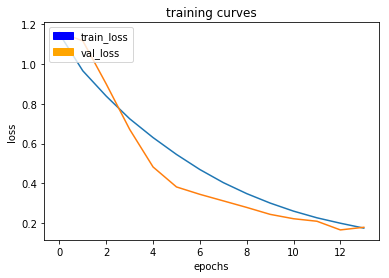

104/104 [==============================] - 142s - loss: 0.1751 - val_loss: 0.1793
Epoch 15/70
103/104 [============================>.] - ETA: 1s - loss: 0.1577

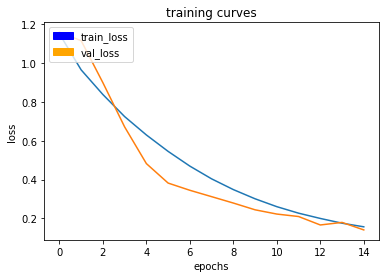

104/104 [==============================] - 143s - loss: 0.1575 - val_loss: 0.1406
Epoch 16/70
103/104 [============================>.] - ETA: 1s - loss: 0.1397

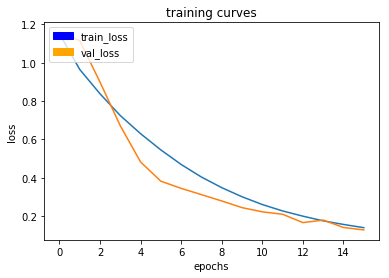

104/104 [==============================] - 141s - loss: 0.1396 - val_loss: 0.1280
Epoch 17/70
103/104 [============================>.] - ETA: 1s - loss: 0.1257

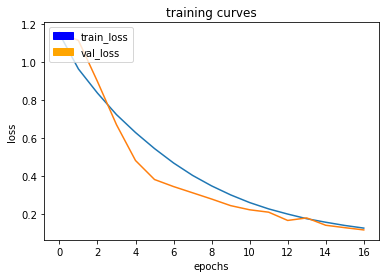

104/104 [==============================] - 138s - loss: 0.1257 - val_loss: 0.1161
Epoch 18/70
103/104 [============================>.] - ETA: 1s - loss: 0.1143

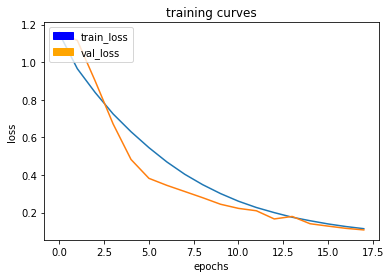

104/104 [==============================] - 133s - loss: 0.1143 - val_loss: 0.1078
Epoch 19/70
103/104 [============================>.] - ETA: 1s - loss: 0.1062

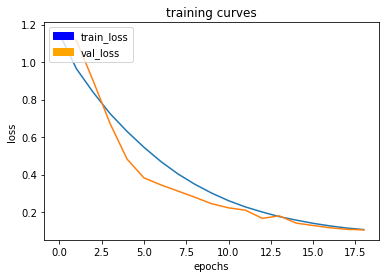

104/104 [==============================] - 136s - loss: 0.1062 - val_loss: 0.1044
Epoch 20/70
103/104 [============================>.] - ETA: 1s - loss: 0.0967

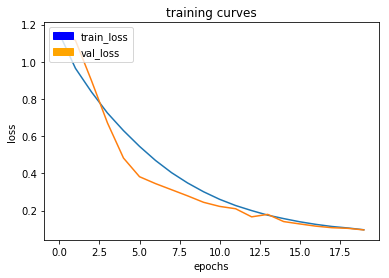

104/104 [==============================] - 142s - loss: 0.0966 - val_loss: 0.0958
Epoch 21/70
103/104 [============================>.] - ETA: 1s - loss: 0.0890

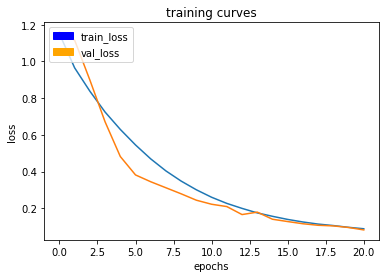

104/104 [==============================] - 139s - loss: 0.0889 - val_loss: 0.0825
Epoch 22/70
103/104 [============================>.] - ETA: 1s - loss: 0.0828

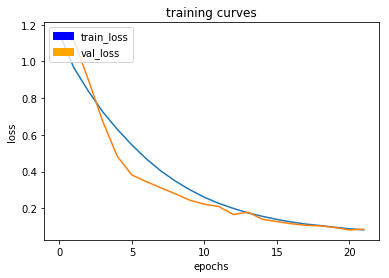

104/104 [==============================] - 137s - loss: 0.0828 - val_loss: 0.0866
Epoch 23/70
103/104 [============================>.] - ETA: 1s - loss: 0.0777

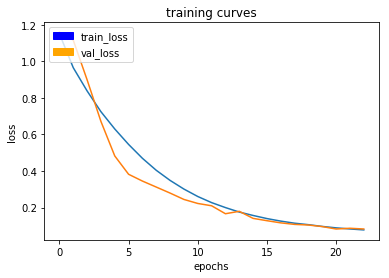

104/104 [==============================] - 143s - loss: 0.0777 - val_loss: 0.0826
Epoch 24/70
103/104 [============================>.] - ETA: 1s - loss: 0.0732

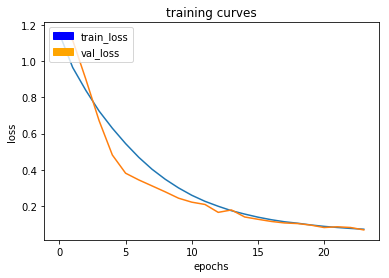

104/104 [==============================] - 138s - loss: 0.0731 - val_loss: 0.0693
Epoch 25/70
103/104 [============================>.] - ETA: 1s - loss: 0.0691

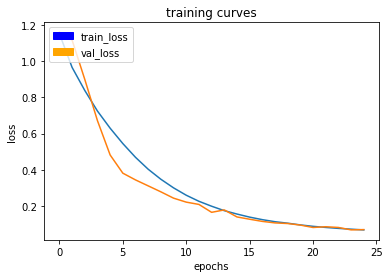

104/104 [==============================] - 136s - loss: 0.0692 - val_loss: 0.0708
Epoch 26/70
103/104 [============================>.] - ETA: 1s - loss: 0.0649

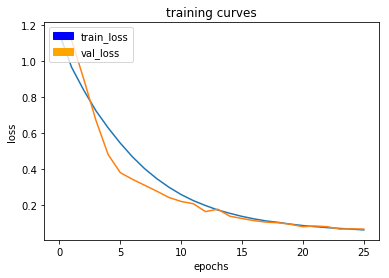

104/104 [==============================] - 137s - loss: 0.0648 - val_loss: 0.0694
Epoch 27/70
103/104 [============================>.] - ETA: 1s - loss: 0.0624

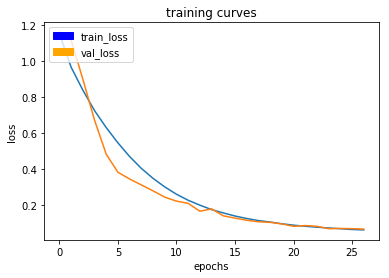

104/104 [==============================] - 139s - loss: 0.0624 - val_loss: 0.0669
Epoch 28/70
103/104 [============================>.] - ETA: 1s - loss: 0.0589

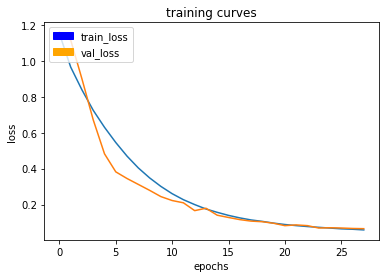

104/104 [==============================] - 132s - loss: 0.0588 - val_loss: 0.0657
Epoch 29/70
103/104 [============================>.] - ETA: 1s - loss: 0.0565

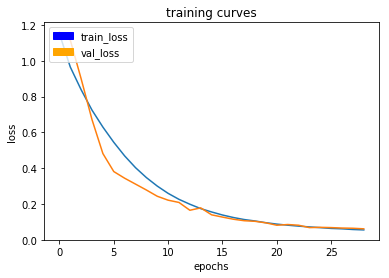

104/104 [==============================] - 132s - loss: 0.0564 - val_loss: 0.0626
Epoch 30/70
103/104 [============================>.] - ETA: 1s - loss: 0.0540

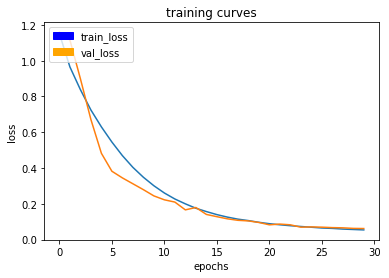

104/104 [==============================] - 129s - loss: 0.0539 - val_loss: 0.0618
Epoch 31/70
103/104 [============================>.] - ETA: 1s - loss: 0.0523

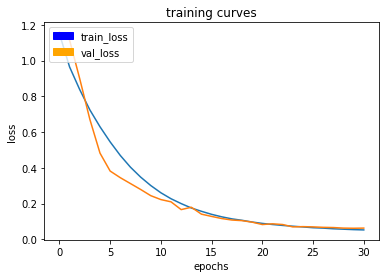

104/104 [==============================] - 139s - loss: 0.0525 - val_loss: 0.0626
Epoch 32/70
103/104 [============================>.] - ETA: 1s - loss: 0.0498

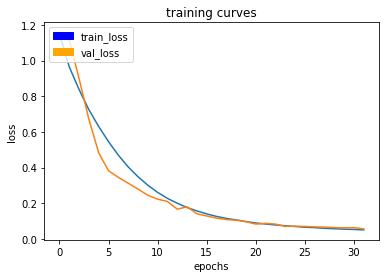

104/104 [==============================] - 145s - loss: 0.0498 - val_loss: 0.0555
Epoch 33/70
103/104 [============================>.] - ETA: 1s - loss: 0.0482

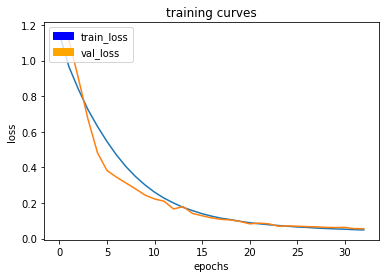

104/104 [==============================] - 133s - loss: 0.0485 - val_loss: 0.0555
Epoch 34/70
103/104 [============================>.] - ETA: 1s - loss: 0.0470

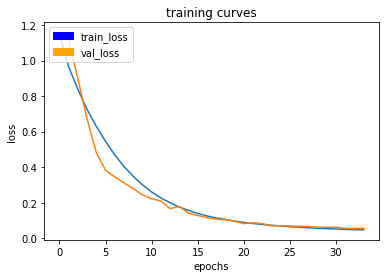

104/104 [==============================] - 138s - loss: 0.0470 - val_loss: 0.0567
Epoch 35/70
103/104 [============================>.] - ETA: 1s - loss: 0.0454

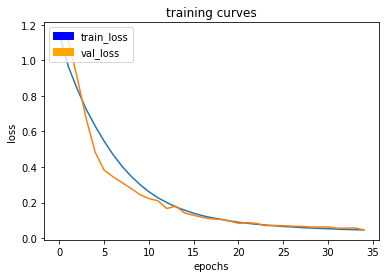

104/104 [==============================] - 138s - loss: 0.0456 - val_loss: 0.0464
Epoch 36/70
103/104 [============================>.] - ETA: 1s - loss: 0.0438

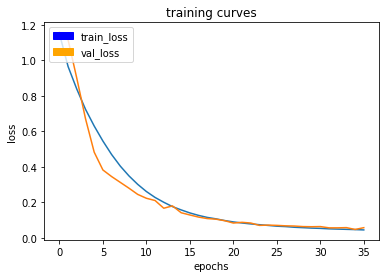

104/104 [==============================] - 138s - loss: 0.0438 - val_loss: 0.0564
Epoch 37/70
103/104 [============================>.] - ETA: 1s - loss: 0.0427

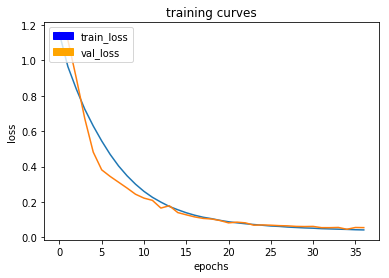

104/104 [==============================] - 142s - loss: 0.0427 - val_loss: 0.0557
Epoch 38/70
103/104 [============================>.] - ETA: 1s - loss: 0.0419

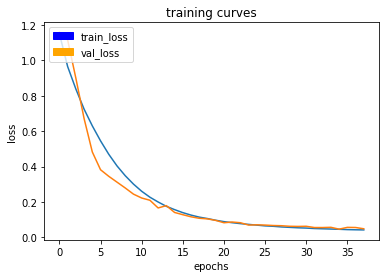

104/104 [==============================] - 140s - loss: 0.0420 - val_loss: 0.0485
Epoch 39/70
103/104 [============================>.] - ETA: 1s - loss: 0.0404

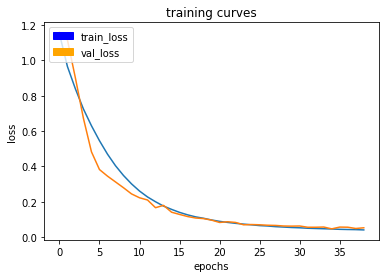

104/104 [==============================] - 144s - loss: 0.0404 - val_loss: 0.0524
Epoch 40/70
103/104 [============================>.] - ETA: 1s - loss: 0.0399

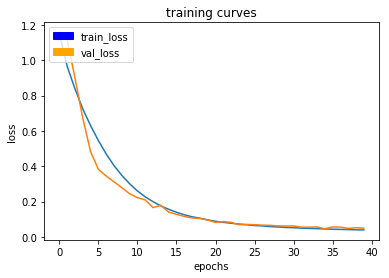

104/104 [==============================] - 143s - loss: 0.0400 - val_loss: 0.0497
Epoch 41/70
103/104 [============================>.] - ETA: 1s - loss: 0.0400

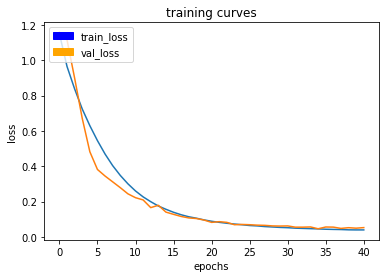

104/104 [==============================] - 140s - loss: 0.0399 - val_loss: 0.0530
Epoch 42/70
103/104 [============================>.] - ETA: 1s - loss: 0.0383

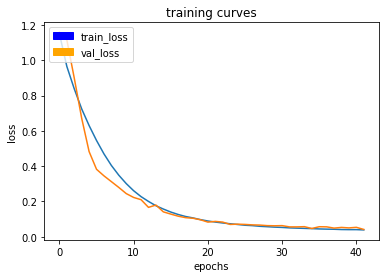

104/104 [==============================] - 147s - loss: 0.0383 - val_loss: 0.0410
Epoch 43/70
103/104 [============================>.] - ETA: 1s - loss: 0.0374

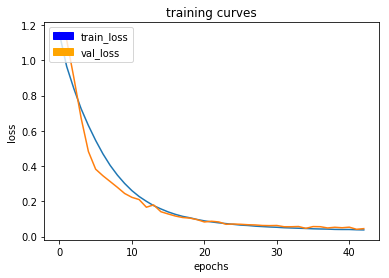

104/104 [==============================] - 134s - loss: 0.0374 - val_loss: 0.0448
Epoch 44/70
103/104 [============================>.] - ETA: 1s - loss: 0.0360

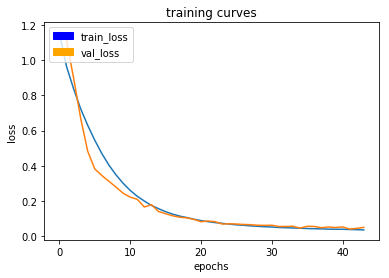

104/104 [==============================] - 130s - loss: 0.0360 - val_loss: 0.0505
Epoch 45/70
103/104 [============================>.] - ETA: 1s - loss: 0.0356

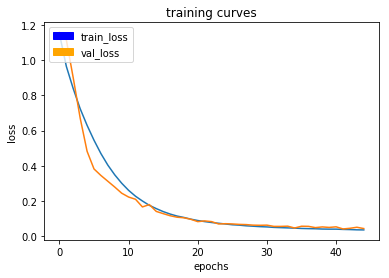

104/104 [==============================] - 130s - loss: 0.0355 - val_loss: 0.0432
Epoch 46/70
103/104 [============================>.] - ETA: 1s - loss: 0.0349

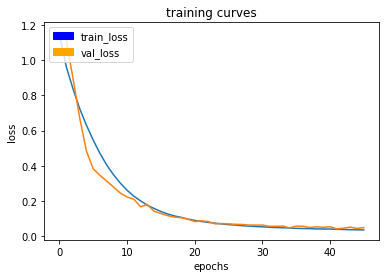

104/104 [==============================] - 128s - loss: 0.0348 - val_loss: 0.0481
Epoch 47/70
103/104 [============================>.] - ETA: 1s - loss: 0.0338

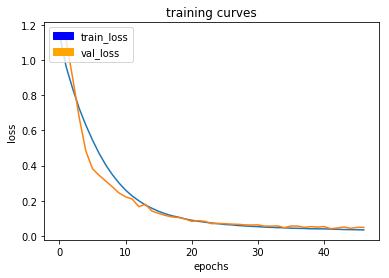

104/104 [==============================] - 128s - loss: 0.0338 - val_loss: 0.0481
Epoch 48/70
103/104 [============================>.] - ETA: 1s - loss: 0.0337

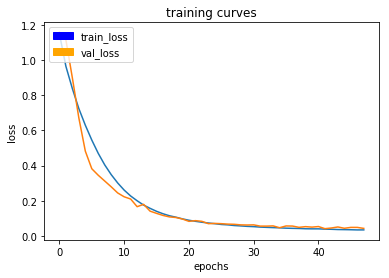

104/104 [==============================] - 126s - loss: 0.0339 - val_loss: 0.0425
Epoch 49/70
103/104 [============================>.] - ETA: 1s - loss: 0.0326

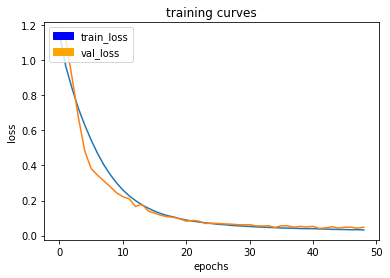

104/104 [==============================] - 129s - loss: 0.0326 - val_loss: 0.0482
Epoch 50/70
103/104 [============================>.] - ETA: 1s - loss: 0.0320

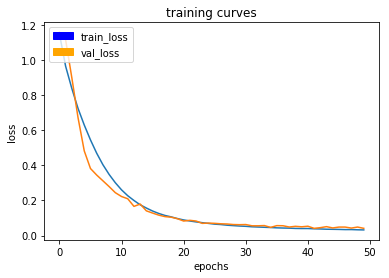

104/104 [==============================] - 126s - loss: 0.0319 - val_loss: 0.0410
Epoch 51/70
103/104 [============================>.] - ETA: 1s - loss: 0.0313

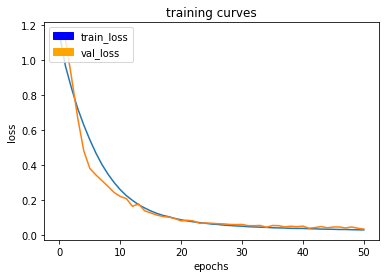

104/104 [==============================] - 126s - loss: 0.0313 - val_loss: 0.0363
Epoch 52/70
103/104 [============================>.] - ETA: 1s - loss: 0.0318

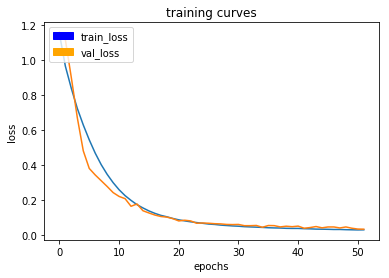

104/104 [==============================] - 126s - loss: 0.0318 - val_loss: 0.0355
Epoch 53/70
103/104 [============================>.] - ETA: 1s - loss: 0.0308

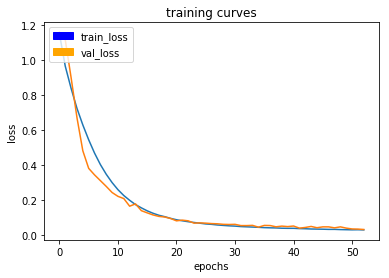

104/104 [==============================] - 127s - loss: 0.0307 - val_loss: 0.0332
Epoch 54/70
103/104 [============================>.] - ETA: 1s - loss: 0.0307

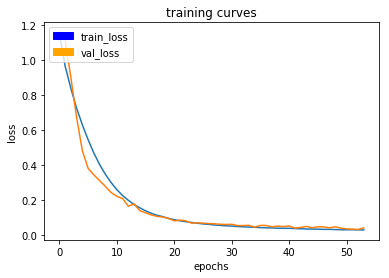

104/104 [==============================] - 126s - loss: 0.0307 - val_loss: 0.0424
Epoch 55/70
103/104 [============================>.] - ETA: 1s - loss: 0.0295

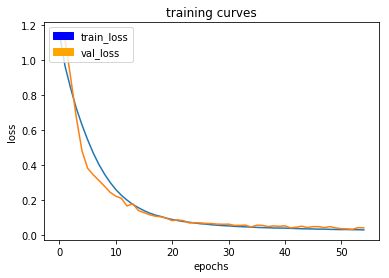

104/104 [==============================] - 126s - loss: 0.0295 - val_loss: 0.0411
Epoch 56/70
103/104 [============================>.] - ETA: 1s - loss: 0.0294

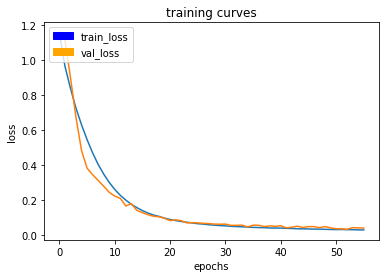

104/104 [==============================] - 126s - loss: 0.0294 - val_loss: 0.0402
Epoch 57/70
103/104 [============================>.] - ETA: 1s - loss: 0.0285

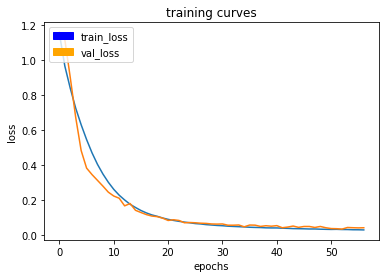

104/104 [==============================] - 127s - loss: 0.0284 - val_loss: 0.0409
Epoch 58/70
103/104 [============================>.] - ETA: 1s - loss: 0.0283

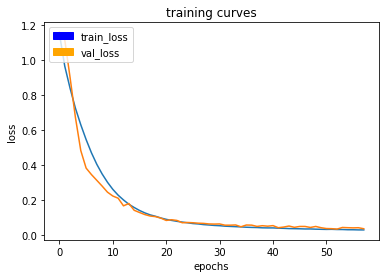

104/104 [==============================] - 125s - loss: 0.0284 - val_loss: 0.0351
Epoch 59/70
103/104 [============================>.] - ETA: 1s - loss: 0.0281

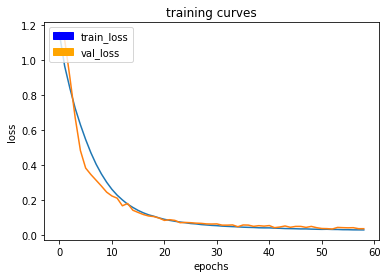

104/104 [==============================] - 125s - loss: 0.0281 - val_loss: 0.0352
Epoch 60/70
103/104 [============================>.] - ETA: 1s - loss: 0.0277

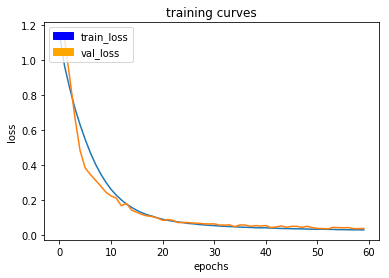

104/104 [==============================] - 125s - loss: 0.0277 - val_loss: 0.0363
Epoch 61/70
103/104 [============================>.] - ETA: 1s - loss: 0.0275

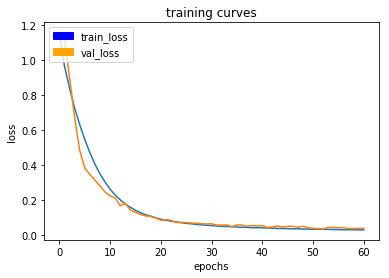

104/104 [==============================] - 125s - loss: 0.0275 - val_loss: 0.0363
Epoch 62/70
103/104 [============================>.] - ETA: 1s - loss: 0.0263

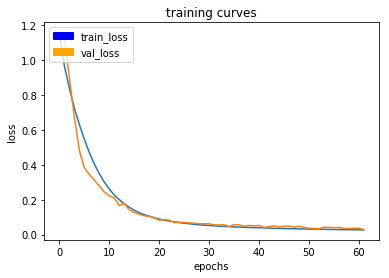

104/104 [==============================] - 125s - loss: 0.0268 - val_loss: 0.0295
Epoch 63/70
103/104 [============================>.] - ETA: 1s - loss: 0.0272

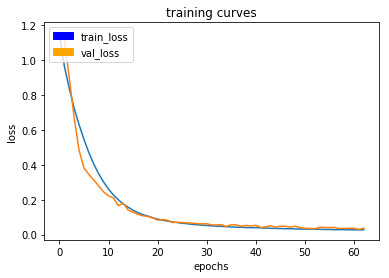

104/104 [==============================] - 125s - loss: 0.0272 - val_loss: 0.0371
Epoch 64/70
103/104 [============================>.] - ETA: 1s - loss: 0.0268

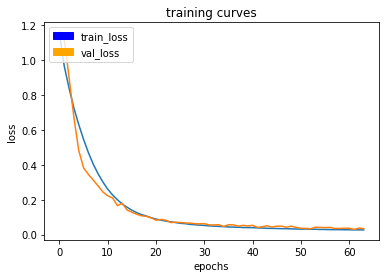

104/104 [==============================] - 125s - loss: 0.0267 - val_loss: 0.0340
Epoch 65/70
103/104 [============================>.] - ETA: 1s - loss: 0.0264

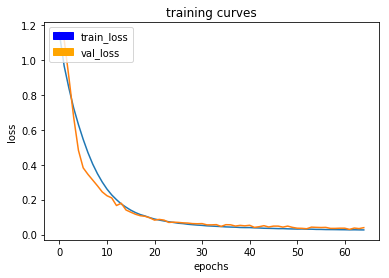

104/104 [==============================] - 125s - loss: 0.0264 - val_loss: 0.0393
Epoch 66/70
103/104 [============================>.] - ETA: 1s - loss: 0.0263

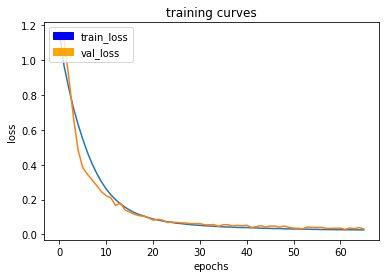

104/104 [==============================] - 125s - loss: 0.0263 - val_loss: 0.0320
Epoch 67/70
103/104 [============================>.] - ETA: 1s - loss: 0.0257

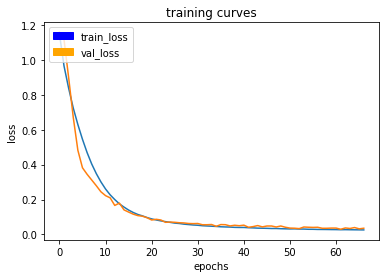

104/104 [==============================] - 125s - loss: 0.0257 - val_loss: 0.0354
Epoch 68/70
103/104 [============================>.] - ETA: 1s - loss: 0.0252

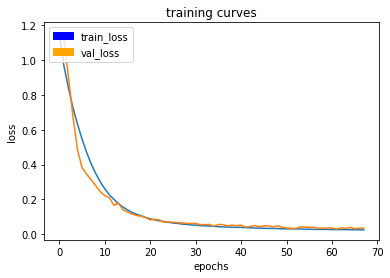

104/104 [==============================] - 125s - loss: 0.0252 - val_loss: 0.0357
Epoch 69/70
103/104 [============================>.] - ETA: 1s - loss: 0.0255

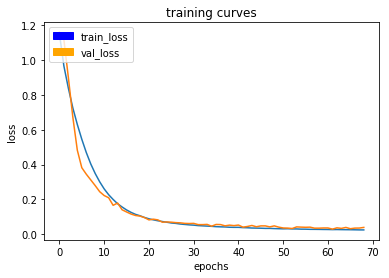

104/104 [==============================] - 125s - loss: 0.0254 - val_loss: 0.0394
Epoch 70/70
103/104 [============================>.] - ETA: 1s - loss: 0.0250

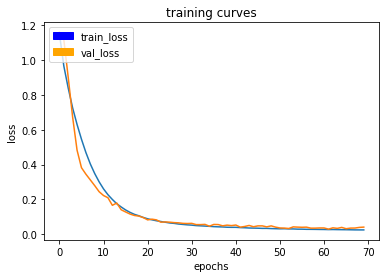

104/104 [==============================] - 125s - loss: 0.0251 - val_loss: 0.0410


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [36]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [37]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [38]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

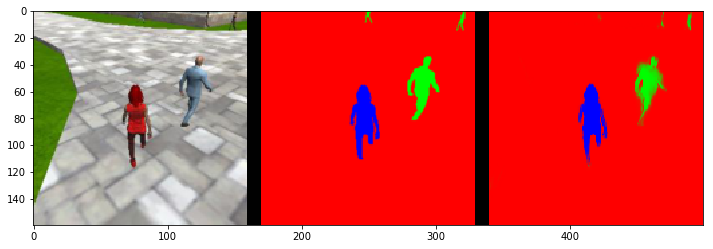

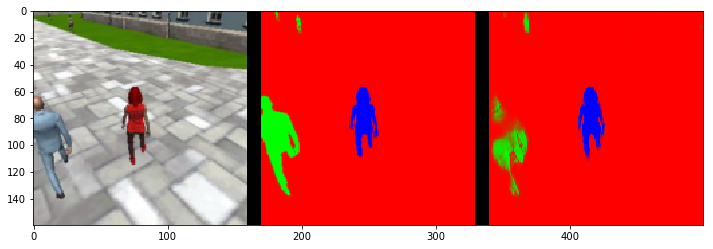

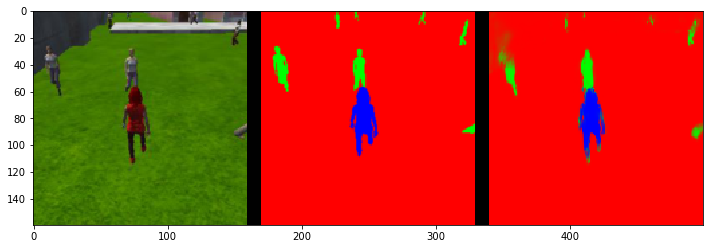

In [39]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

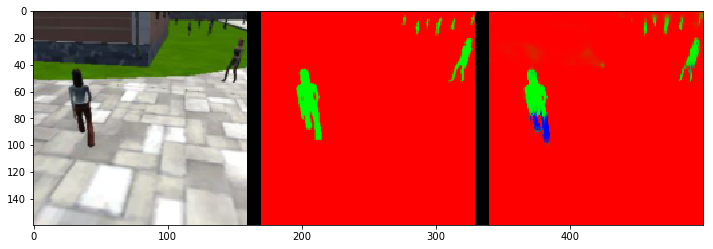

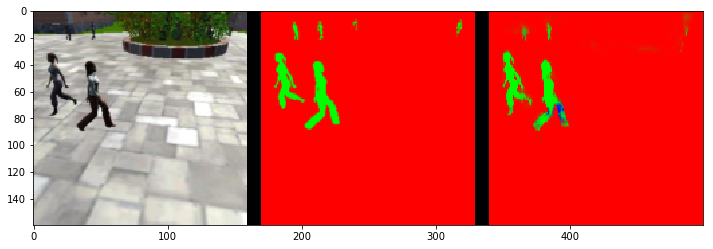

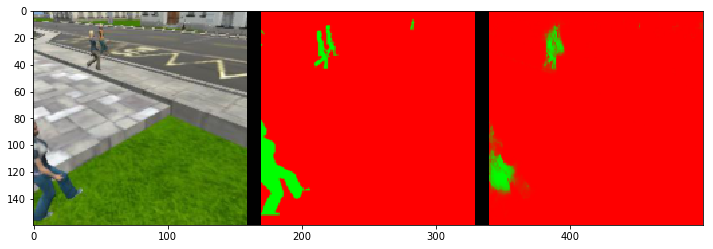

In [40]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

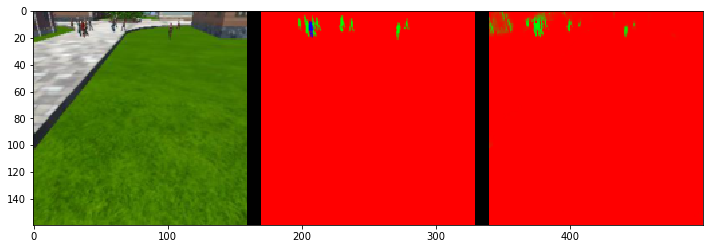

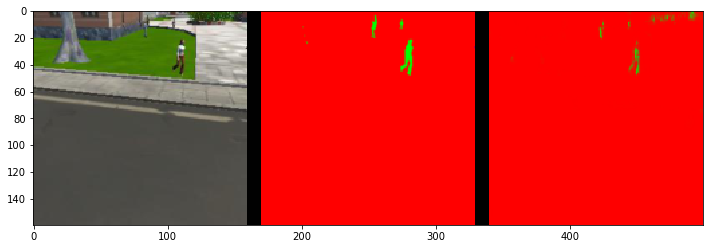

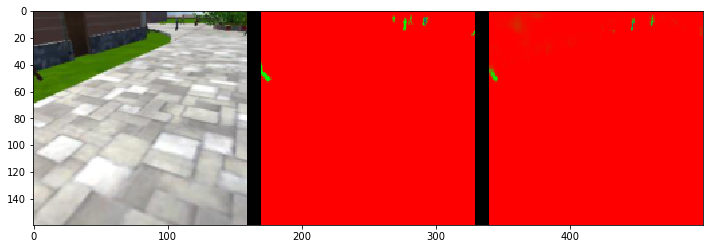

In [41]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [42]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9938776396792606
average intersection over union for other people is 0.2687873386273839
average intersection over union for the hero is 0.8577244126392904
number true positives: 539, number false positives: 0, number false negatives: 0


In [43]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9813562254645439
average intersection over union for other people is 0.6296780380421474
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 36, number false negatives: 0


In [44]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9951420543143091
average intersection over union for other people is 0.3459862220953533
average intersection over union for the hero is 0.06186384401119427
number true positives: 54, number false positives: 1, number false negatives: 247


In [45]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6761687571265679


In [46]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.459794128325


In [47]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.310898424284
